**Projeto da disciplina de Data Mining**

**PESC - Programa de Engenharia de Sistemas e Computação**

**COPPE / UFRJ**

Autores: Bernardo Souza e Rafael Lopes Conde dos Reis

GitHub: https://github.com/condereis/credit-card-default/


# Resumo



# Setup

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import randint, uniform

from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

import tensorflow as tf
import tflearn
from tflearn.data_utils import to_categorical

%matplotlib inline

In [2]:
train = pd.read_csv('../data/processed/train.csv', index_col=0)
test = pd.read_csv('../data/processed/test.csv', index_col=0)

del train.index.name
del test.index.name

X_train = train.drop('default.payment.next.month', axis=1)
X_train_red = PCA(n_components=10).fit_transform(X_train)
y_train = train['default.payment.next.month']

X_test = test.drop('default.payment.next.month', axis=1)
X_test_red = PCA(n_components=10).fit_transform(X_test)
y_test = test['default.payment.next.month']

def get_crossval(model, scoring='accuracy', knn=False):
    result_list = cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1, scoring=scoring)
    if knn:
        result_list = cross_val_score(model, X_train_red, y_train, cv=5, n_jobs=-1, scoring=scoring)
    return '%.3f +- %.3f' % (np.mean(result_list), np.std(result_list))

def get_auc(model, knn=False):
    y_pred = [y[1] for y in model.fit(X_train, y_train).predict_proba(X_test)]
    if knn:
        y_pred = [y[1] for y in model.fit(X_train_red, y_train).predict_proba(X_test_red)]
    fpr, tpr, _ = roc_curve(y_test+1, y_pred, pos_label=2)
    return auc(fpr, tpr)

def get_accuracy(model, knn=False):
    y_pred = model.fit(X_train, y_train).predict(X_test)
    if knn:
        y_pred = model.fit(X_train_red, y_train).predict(X_test_red)
    return accuracy_score(y_test, y_pred)

def plot_roc(model, label, knn=False):
    y_pred = [y[1] for y in model.fit(X_train, y_train).predict_proba(X_test)]
    if knn:
        y_pred = [y[1] for y in model.fit(X_train_red, y_train).predict_proba(X_test_red)]
    fpr, tpr, _ = roc_curve(y_test+1, y_pred, pos_label=2)
    plt.plot(fpr, tpr, label=label)
    plt.plot([0, 1], [0, 1], color='navy',linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title(u'Comparação dos Modelos')
    plt.legend(loc="lower right")
    
def plot_conf_mtx(model, title, pos, knn=False):
    y_pred = model.fit(X_train,y_train).predict(X_test)
    if knn:
        y_pred = model.fit(X_train_red,y_train).predict(X_test_red)
    columns = ['Pago', 'Default']
    index = ['Pago', 'Default']
    if pos[0]==0:
        columns = ['', '']
    if pos[1]==1:
        index = ['', '']
    mtx = confusion_matrix(y_test, y_pred)
    mtx = [x/float(sum(x)) for x in mtx]
    sns.heatmap(pd.DataFrame(mtx, columns=columns, index=index), annot=True, fmt=".2f", linewidths=.5)
    if pos[0]==1:
        plt.xlabel('Valor Classificado')
    if pos[1]==0:
        plt.ylabel('Valor Real')
    plt.title(title)

# Comparação

## Curvas ROC

Observando as curvas ROC dos modelos, plotadas juntas, observamos que a curva do Gradient Boosting Trees, se manteve assima das demais o tempo todos, ou seja, para qualquer valor que escolhermos como limiar de operação ele irá ter um desempenho superior aos demais.

Os demais modelos apresentaram um desempenho relativamente semelhante, de forma que o segundo melhor modelo dependo do ponto de operação que se utilizar.

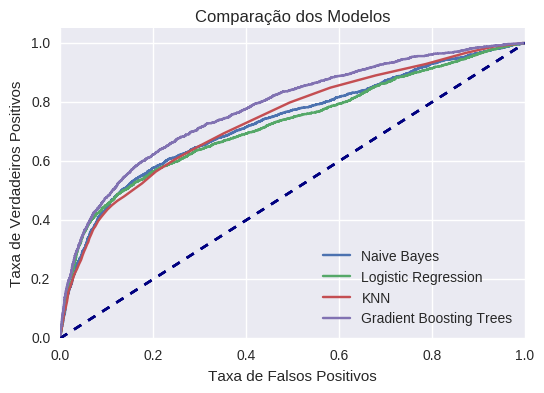

In [3]:
nb = GaussianNB()
lr = LogisticRegression(C=10)
knn = KNeighborsClassifier(n_neighbors=62)
gbt = GradientBoostingClassifier(max_features=0.2)

plt.figure()
plot_roc(nb, 'Naive Bayes')
plot_roc(lr, 'Logistic Regression')
plot_roc(knn, 'KNN', True)
plot_roc(gbt, 'Gradient Boosting Trees')
plt.show()

## Área sob as curvas ROC

O que foi observado nas curvas ROC é sesumido na tabela abaixo, que mostra o Gradient Boosting Trees quase 5 pontos percentuais acima do melhor modelo e quase 7 pontos acima do pior.

In [4]:
roc = pd.DataFrame()

roc.set_value('Naive Bayes', '5-fold CV', get_crossval(nb, 'roc_auc'))
roc.set_value('KNN', '5-fold CV', get_crossval(knn, 'roc_auc', True))
roc.set_value('Logistic Regression', '5-fold CV', get_crossval(lr, 'roc_auc'))
roc.set_value('Gradient Boosting Trees', '5-fold CV', get_crossval(gbt, 'roc_auc'))

roc.set_value('Naive Bayes', 'Conjunto de Teste', get_auc(nb))
roc.set_value('KNN', 'Conjunto de Teste', get_auc(knn, True))
roc.set_value('Logistic Regression', 'Conjunto de Teste', get_auc(lr))
roc.set_value('Gradient Boosting Trees', 'Conjunto de Teste', get_auc(gbt))

roc

,5-fold CV,Conjunto de Teste
Naive Bayes,0.737 +- 0.009,0.730897
KNN,0.757 +- 0.008,0.740465
Logistic Regression,0.724 +- 0.012,0.722248
Gradient Boosting Trees,0.782 +- 0.010,0.782132


## Acurácias

Por último são comparadas as eficiências utilizando como ponto de operação 0.5, ou seja, caso o valor retornado polo modelo esteja acima de 0.5 a amostra é classificada como 1 (default), caso seja abaixo é classificada como 0 (pago).

Podemos observar que nesta configuração Naive Bayes tem uma queda drástica no seu resultado, enquanto KNN e Logistic Regression ficaram mais próximos do resultado do Gradient Boosting Trees, embora este ainda tenha sido superior.

In [5]:
accuracy = pd.DataFrame()

accuracy.set_value('Naive Bayes', '5-fold CV', get_crossval(nb))
accuracy.set_value('Logistic Regression', '5-fold CV', get_crossval(lr))
accuracy.set_value('KNN', '5-fold CV', get_crossval(knn, 'accuracy', True))
accuracy.set_value('Gradient Boosting Trees', '5-fold CV', get_crossval(gbt))

accuracy.set_value('Naive Bayes', 'Conjunto de Teste', get_accuracy(nb))
accuracy.set_value('Logistic Regression', 'Conjunto de Teste', get_accuracy(lr))
accuracy.set_value('KNN', 'Conjunto de Teste', get_accuracy(knn, True))
accuracy.set_value('Gradient Boosting Trees', 'Conjunto de Teste', get_accuracy(gbt))

accuracy

,5-fold CV,Conjunto de Teste
Naive Bayes,0.604 +- 0.031,0.610778
Logistic Regression,0.810 +- 0.005,0.807444
KNN,0.811 +- 0.004,0.803000
Gradient Boosting Trees,0.822 +- 0.005,0.817667


## Matrizes de Confusão

Ainda tratando da operação em 0.5, podemos observar que os modelos, com excessão do Naive Bayes, possuem uma taxa de acerto muito alta de detecção de pagadores, porém apresentam um resultado ruim na detecção de defaults. O Naive Bayes, apresentou a taxa mais alta dentre eles na detecção de defaults, porém teve um resultado bastante abaixo na detecção de pagadores.

Como foi visto anteriormente, Gradient Boosting Trees apresenta uma curva ROC superior do que a dos demais modelos. Portanto bastaria variar o limiar de corte para um valor que permita maior equilíbrio entre detecção e falso alarme. Para isso utilizou-se F1-score.

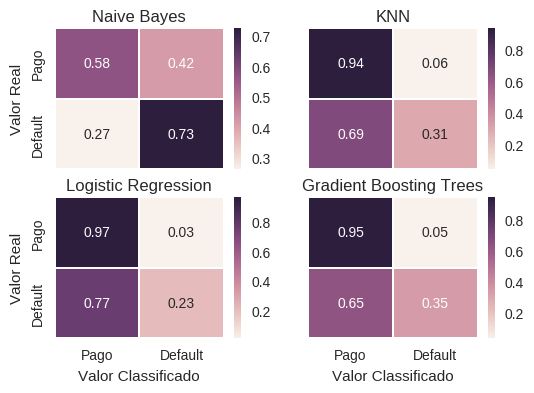

In [6]:
plt.subplot(221)
plot_conf_mtx(nb, 'Naive Bayes', pos=(0,0))
plt.subplot(222)
plot_conf_mtx(knn, 'KNN', pos=(0,1), knn=True)
plt.subplot(223)
plot_conf_mtx(lr, 'Logistic Regression', pos=(1,0))
plt.subplot(224)
plot_conf_mtx(gbt, 'Gradient Boosting Trees', pos=(1,1))

## Máximo F1-score

F1-score é uma métrica para classificadores binários que considera tanto a taxa de detecção quanto a de falso alarme no seu cálculo, fazendo uma especie de média harmónica de ambas. Ao calcular o f1-score para diferentes limiares de corte pode-se observar que ele possui um ponto máximo. Ulilizando este ponto como limiar de corte o modelo apresentou a matiz de confusão descrita abaixo, muito mais equilibranda que a primeira.

Máximo F1-score: 0.710786228983
Limiar de corte: 0.710786228983


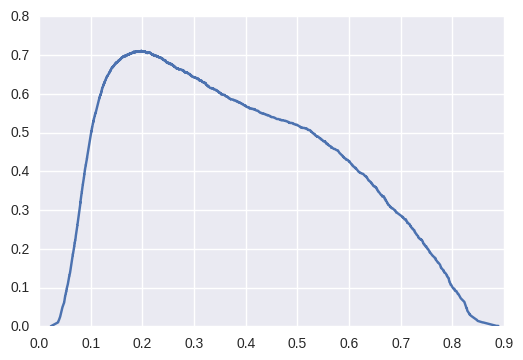

In [7]:
def get_f1(fpr, tpr):
    return 2 * tpr * (1-fpr) / (tpr + 1-fpr)
y_pred = [y[1] for y in gbt.fit(X_train, y_train).predict_proba(X_test)]
fpr_l, tpr_l, tsh_l = roc_curve(y_test+1, y_pred, pos_label=2)
f1_list = []
for fpr, tpr in zip(fpr_l, tpr_l):
    f1_list.append(get_f1(fpr, tpr))
print 'Máximo F1-score:', max(f1_list)
print 'Limiar de corte:', (max(f1_list))

plt.plot(tsh_l, f1_list)

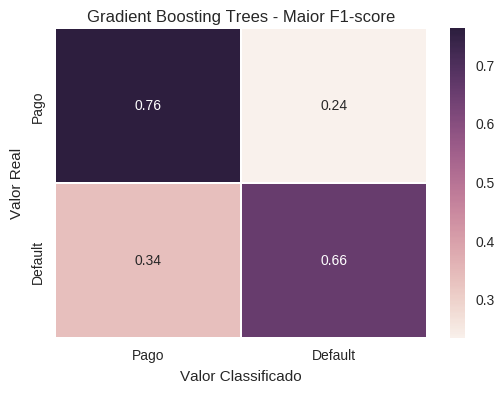

In [8]:
thd = 0.2
def get_value(y):
    if y > thd:
        return 1
    else:
        return 0
y_pred = [get_value(y) for y in y_pred]
labels = ['Pago', 'Default']
mtx = confusion_matrix(y_test, y_pred)
mtx = [x/float(sum(x)) for x in mtx]
sns.heatmap(pd.DataFrame(mtx, columns=labels, index=labels), annot=True, fmt=".2f", linewidths=.5)
plt.xlabel('Valor Classificado')
plt.ylabel('Valor Real')
plt.title('Gradient Boosting Trees - Maior F1-score')

## Conclusão

Dos modelos testados o Gradient Boosting Trees apresentou o melhor resultado para qualquer ponto de operação. Os dados foram pré-processados de forma a:
* Tratar a variável MARRIAGE como uma booleana indicando casado ou não casado;
* Juntar as classes others e unknown em EDUCATION em uma só e criar uma variável dummy cara cada classe;
* Criar uma variável sintética igual a soma dos ultimos pagamentos menos a soma das últimas faturas dividido pelo limite do cartão;
* Substituir as demais variáveis pelos seus valores de z-score.

A melhor configuração do modelo para estes dados, utilizou os seguintes parâmetros sem nenhuma redução de dimensionalidade:
* Taxa de Aprendizado: 0.1
* Subamostragem: 1
* Numero de features a se considerar para um split: 20%
* Máxima Profundidade: 3
* Mínimo de amostras para um split: 2
* Mínimo de amostras em uma folha: 1
* Limiar de classificação: 0.2
